In [73]:
cd /home/dmoi/projects/foldtree2/

/home/dmoi/projects/foldtree2


In [74]:
import sys
sys.path.append('/home/dmoi/projects/foldtree2')
#read the afdb clusters file
import pandas as pd
import numpy as np
import glob
import os
#autoreload
import pickle
from src import AFDB_tools
import toytree
import tqdm
from matplotlib import pyplot as plt
import torch
from converter import pdbgraph
converter = pdbgraph.PDB2PyG()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [75]:
modelname = 'small5_geo_graph'

with open( modelname + '.pkl', 'rb') as f:
	encoder, decoder = pickle.load(f)

encoder.eval()
decoder.eval()	
encoder.to(device)
decoder.to(device)

HeteroGAE_Decoder(
  (convs): ModuleList(
    (0-4): 5 x HeteroConv(num_relations=2)
  )
  (norms): ModuleList(
    (0-4): 5 x LayerNorm((50,), eps=1e-05, elementwise_affine=True)
  )
  (bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_foldx): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.001, inplace=False)
  (jk): JumpingKnowledge(cat)
  (sigmoid): Sigmoid()
  (lin): Sequential(
    (0): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=250, out_features=400, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=400, out_features=400, bias=True)
    (4): GELU(approximate='none')
    (5): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
  )
  (aadecoder): Sequential(
    (0): Linear(in_features=420, out_features=200, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=200, out_features=100, bias=True)
    (3):

In [76]:
from torch_geometric.data import DataLoader , HeteroData

struct_dat = pdbgraph.StructureDataset('structalignmk4.h5')
#struct_dat = ft2.StructureDataset('structs_training.h5')
encoder_loader = DataLoader(struct_dat, batch_size=1, shuffle=True)
#encode the structures
encode_alns = True
if encode_alns == True:
	def databatch2list(loader , limit = 10):
		for i,data in enumerate(loader):
			if i > limit:
				break
			data = data.to_data_list()
			for d in data:
				d = d.to(device)
				yield d
	encoder_loader = databatch2list(encoder_loader)
	encoder.encode_structures_fasta(encoder_loader , modelname+'_aln_encoded_test.fasta' )

/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
11it [00:00, 19.85it/s]


In [77]:
encoded_fasta =  modelname+'_aln_encoded_test.fasta' 
seqstr = ''
ID = ''
seqdict = {}
with open(encoded_fasta, 'r') as f:
	#read all chars of file into a string
	for line in tqdm.tqdm(f):
		if line[0] == '>' and line[-1] == '\n':
			seqdict[ID] = seqstr
			ID = line[1:].strip()
			seqstr = ''
		else:
			seqstr += line.strip()
del seqdict['']
encoded_df = pd.DataFrame( seqdict.items() , columns=['protid', 'seq'] )
#change index to protid
encoded_df.index = encoded_df.protid
encoded_df = encoded_df.drop( 'protid', axis=1 )

encoded_df['ord'] = encoded_df.seq.map( lambda x: [ ord(c) for c in x] )
#hex starts at 1
encoded_df['hex2'] = encoded_df.ord.map( lambda x: [ hex(c) for c in x] )

156it [00:00, 647833.09it/s]


In [78]:
charset = 249
#make fasta is shifted by 1 and goes from 1-248 included
#0x01 – 0xFF excluding > (0x3E), = (0x3D), < (0x3C), - (0x2D), Space (0x20), Carriage Return (0x0d) and Line Feed (0x0a)
#replace 0x22 or " which is necesary for nexus files and 0x23 or # which is also necesary

replace_dict = {chr(0):chr(246) , '"':chr(248) , '#':chr(247), '>' : chr(249), '=' : chr(250), '<' : chr(251), '-' : chr(252), ' ' : chr(253) , '\r' : chr(254), '\n' : chr(255) }
rev_replace_dict = { v:k for k,v in replace_dict.items() }

replace_dict_ord = { ord(k):ord(v) for k,v in replace_dict.items() }
rev_replace_dict_ord = { ord(v):ord(k) for k,v in replace_dict.items() }

print(replace_dict)
print(rev_replace_dict)

print( replace_dict_ord )

print(rev_replace_dict_ord)

{'\x00': 'ö', '"': 'ø', '#': '÷', '>': 'ù', '=': 'ú', '<': 'û', '-': 'ü', ' ': 'ý', '\r': 'þ', '\n': 'ÿ'}
{'ö': '\x00', 'ø': '"', '÷': '#', 'ù': '>', 'ú': '=', 'û': '<', 'ü': '-', 'ý': ' ', 'þ': '\r', 'ÿ': '\n'}
{0: 246, 34: 248, 35: 247, 62: 249, 61: 250, 60: 251, 45: 252, 32: 253, 13: 254, 10: 255}
{246: 0, 248: 34, 247: 35, 249: 62, 250: 61, 251: 60, 252: 45, 253: 32, 254: 13, 255: 10}


In [79]:
encoded_df.seq = encoded_df.seq.map(lambda x : ''.join([ c if c not in replace_dict else replace_dict[c] for c in x]))
print(encoded_df)

                                                          seq  \
protid                                                          
A0A2S5ACI1  (((((((ýý\t\t((ýýýýýýýýýýýýýý...   
A0A2E7GJE0  ÷ýýýý(\tý...   
A0A1X4HUU7  '...   
A0A0P9RMJ5  ÷ýýýýýýýýýýýýýýýýýýý\t\t\t\t\t...   
A0A0B7FXL7  (\t\t((\t(\t(\t\týýýýýýýýý\t\t\t\t\t\t\t\...   
A0A380WB87 ýýý÷÷÷ýýýýýýýý÷\t...   
A0A3S4LZB0  ...   
D6PJR2      ýý\týýýýýýýýýý...   
A0A328BRH7  ÷÷÷...   
A0A6J6ZCZ6  ''÷ýýýýýý\...   

                                                          ord  \
protid                                                          
A0A2S5ACI1  [40, 40, 40, 40, 40, 40, 40, 32, 32, 9, 9, 40,...   
A0A2E7GJE0  [1, 20, 1, 12, 12, 12, 20, 16, 1, 8, 4, 40, 8,...   
A0A1X4HUU7  [27

In [80]:
import py3Dmol

def view_custom_pdb(pdb_file, chain='A'):
	"""
	Visualize a PDB structure from a file, highlight a specific residue with thicker sticks,
	show the backbone for the selected residue, and add an arrow-like indicator.
	
	Parameters:
	- pdb_file: str, path to the local PDB file.
	- residue_num: int, residue number to highlight.
	- chain: str, the chain identifier (default 'A').
	"""
	# Read the PDB file content
	with open(pdb_file, 'r') as f:
		pdb_content = f.read()

	# Initialize py3Dmol viewer
	viewer = py3Dmol.view(width=800, height=600)
	
	# Add the PDB structure to the viewer
	viewer.addModel(pdb_content, 'pdb')
	
	# Apply cartoon style for the overall structure
	viewer.setStyle({'cartoon': {'color': 'cyan'}})
	
	
	# Add molecular surface for the rest of the structure
	viewer.addSurface(py3Dmol.VDW, {'opacity': 0.5})
	
	
	# Set zoom and background color
	viewer.zoomTo()
	viewer.setBackgroundColor('white')
	
	# Show the structure
	return viewer.show()



A0A2S5ACI1


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

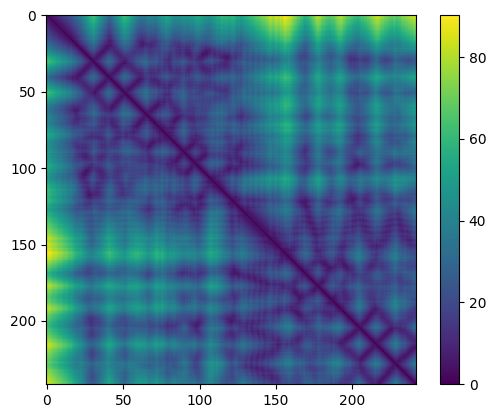

242
torch.Size([242, 20])
HeteroData(
  res={
    x=[242, 20],
    batch=[242],
  },
  positions={ x=[242, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 241] },
  (res, backbone_rev, res)={ edge_index=[2, 241] },
  (godnode4decoder, informs, res)={ edge_index=[2, 242] },
  (res, informs, godnode4decoder)={ edge_index=[2, 242] },
  (res, informs, godnode)={ edge_index=[2, 242] }
)
torch.Size([58564])
tensor([[-4.1216, -2.3353, -2.5494,  ..., -4.9467, -4.8347, -4.2902],
        [-4.1216, -2.3353, -2.5494,  ..., -4.9467, -4.8347, -4.2902],
        [-4.1118, -2.3307, -2.5547,  ..., -4.9772, -4.8608, -4.2779],
        ...,
        [-1.6154, -3.4740, -4.7791,  ..., -7.8357, -8.2730, -1.9074],
        [-1.8795, -2.9116, -4.3648,  ..., -7.6446, -8.0857, -2.0754],
        [-1.3102, -3.6504, -4.6592,  ..., -7.9236, -8.2795, -1.8478]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ...,

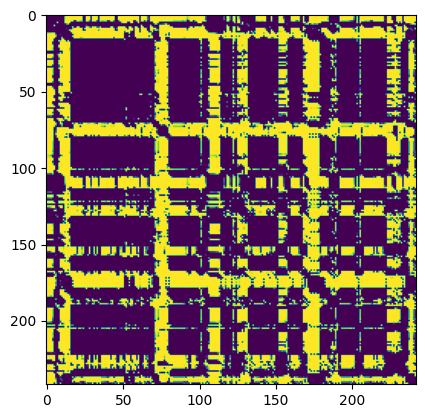

torch.Size([242, 242])
(242, 242)


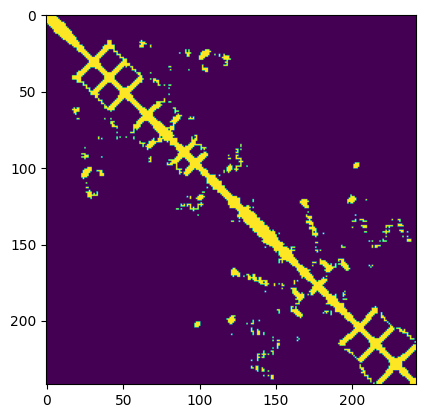

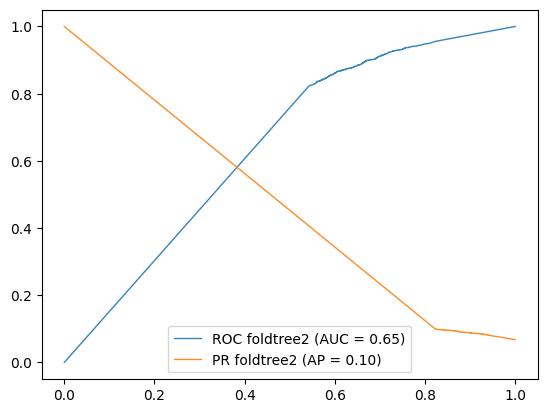

A0A2E7GJE0


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

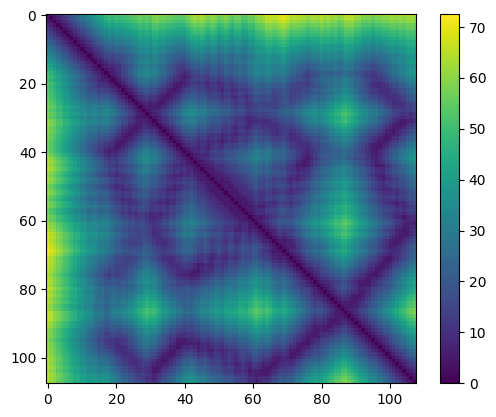

108
torch.Size([108, 20])
HeteroData(
  res={
    x=[108, 20],
    batch=[108],
  },
  positions={ x=[108, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 107] },
  (res, backbone_rev, res)={ edge_index=[2, 107] },
  (godnode4decoder, informs, res)={ edge_index=[2, 108] },
  (res, informs, godnode4decoder)={ edge_index=[2, 108] },
  (res, informs, godnode)={ edge_index=[2, 108] }
)
torch.Size([11664])
tensor([[-6.5852, -2.1313, -1.9696,  ..., -4.4811, -3.8702, -5.4627],
        [-2.8109, -3.8289, -4.6184,  ..., -7.3033, -7.4263, -2.2880],
        [-6.7698, -4.4303, -4.3065,  ..., -6.7685, -6.1151, -5.9858],
        ...,
        [-1.8821, -3.0284, -4.3322,  ..., -7.6567, -8.0572, -1.9978],
        [-3.5404, -2.5041, -2.4037,  ..., -6.2131, -5.5826, -3.8117],
        [-2.9138, -3.0745, -3.5087,  ..., -6.9131, -6.5969, -4.1176]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ...,

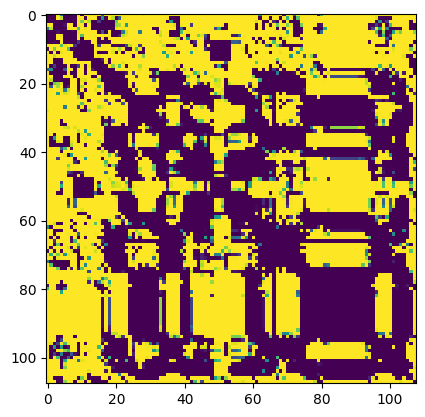

torch.Size([108, 108])
(108, 108)


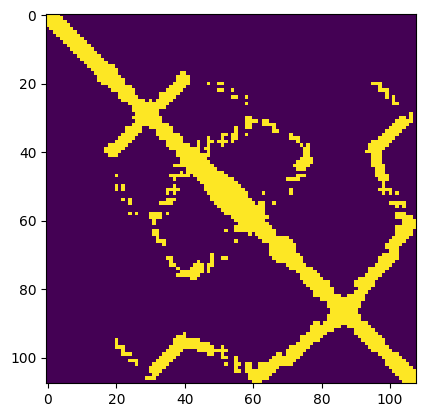

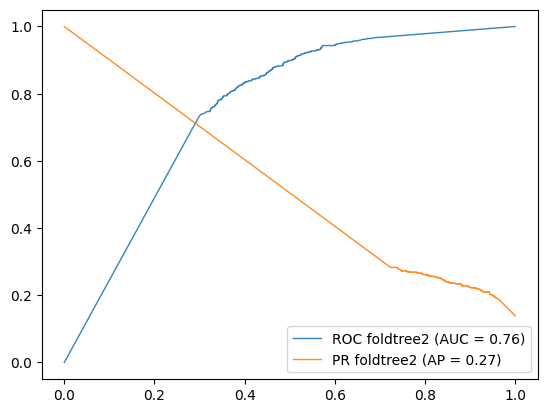

A0A1X4HUU7


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

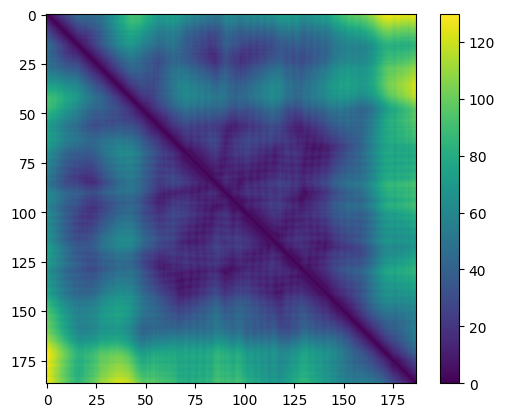

149
torch.Size([149, 20])
HeteroData(
  res={
    x=[149, 20],
    batch=[149],
  },
  positions={ x=[149, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 148] },
  (res, backbone_rev, res)={ edge_index=[2, 148] },
  (godnode4decoder, informs, res)={ edge_index=[2, 149] },
  (res, informs, godnode4decoder)={ edge_index=[2, 149] },
  (res, informs, godnode)={ edge_index=[2, 149] }
)
torch.Size([22201])
tensor([[-3.9488, -2.5481, -2.9091,  ..., -5.6289, -5.0849, -5.2002],
        [-1.1230, -4.3821, -4.7467,  ..., -7.7704, -7.8033, -1.8653],
        [-3.7287, -2.8461, -3.1920,  ..., -6.1079, -5.6941, -4.7813],
        ...,
        [-4.2212, -2.4505, -2.9265,  ..., -5.4692, -4.8013, -5.2254],
        [-1.3660, -4.5707, -4.9633,  ..., -7.4463, -7.9892, -1.7870],
        [-4.9508, -1.9754, -2.9145,  ..., -5.3810, -4.7260, -3.7420]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ...,

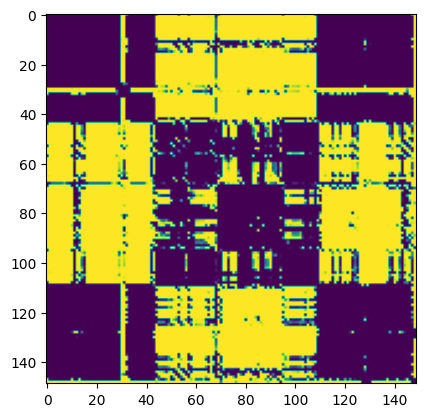

torch.Size([149, 149])
(187, 187)


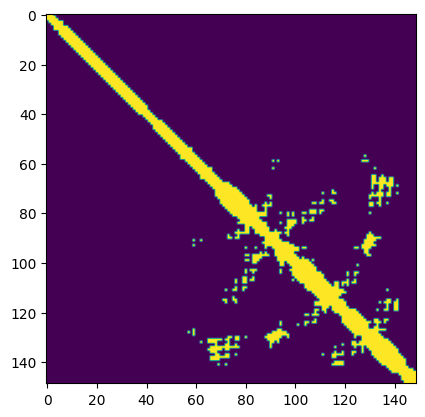

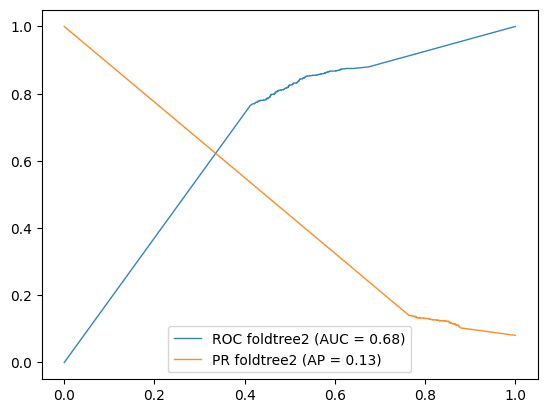

A0A0P9RMJ5


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

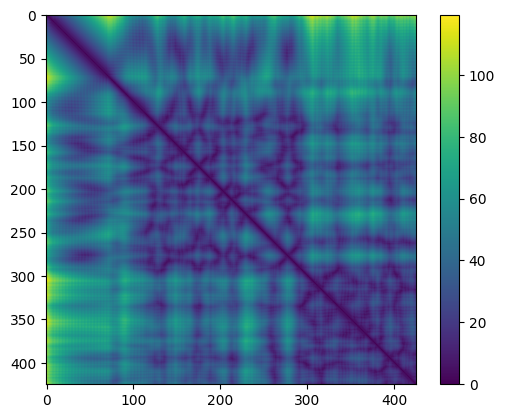

394
torch.Size([394, 20])
HeteroData(
  res={
    x=[394, 20],
    batch=[394],
  },
  positions={ x=[394, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 393] },
  (res, backbone_rev, res)={ edge_index=[2, 393] },
  (godnode4decoder, informs, res)={ edge_index=[2, 394] },
  (res, informs, godnode4decoder)={ edge_index=[2, 394] },
  (res, informs, godnode)={ edge_index=[2, 394] }
)
torch.Size([155236])
tensor([[-6.0482, -1.9649, -2.4603,  ..., -4.9850, -4.3935, -5.0104],
        [-3.6880, -2.3911, -3.6234,  ..., -5.9307, -5.7304, -2.8915],
        [-2.8845, -3.5369, -4.0765,  ..., -6.2629, -6.4232, -2.2188],
        ...,
        [-4.9773, -2.3384, -2.4833,  ..., -5.1207, -4.5408, -5.2420],
        [-5.1286, -2.5177, -2.5524,  ..., -5.4910, -4.9032, -4.7233],
        [-1.6952, -3.3949, -4.6254,  ..., -7.6849, -8.2071, -1.9220]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ...

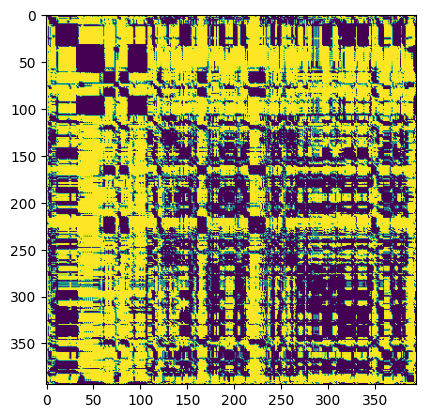

torch.Size([394, 394])
(425, 425)


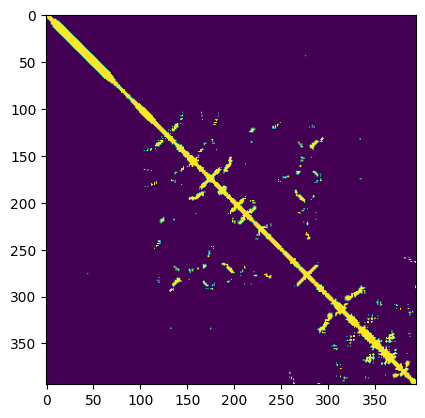

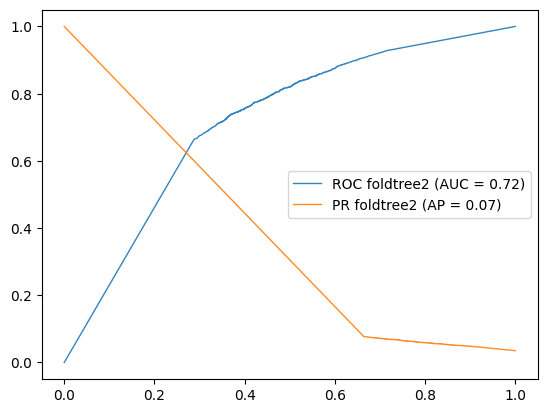

A0A0B7FXL7


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

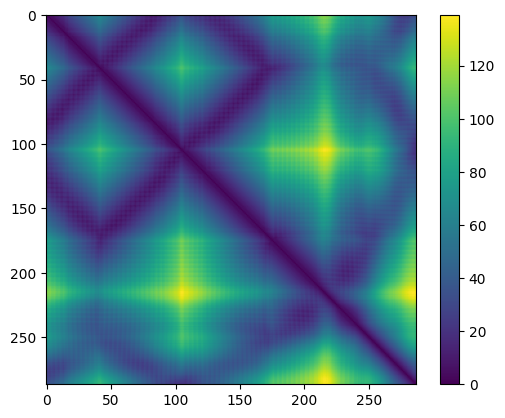

273
torch.Size([273, 20])
HeteroData(
  res={
    x=[273, 20],
    batch=[273],
  },
  positions={ x=[273, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 272] },
  (res, backbone_rev, res)={ edge_index=[2, 272] },
  (godnode4decoder, informs, res)={ edge_index=[2, 273] },
  (res, informs, godnode4decoder)={ edge_index=[2, 273] },
  (res, informs, godnode)={ edge_index=[2, 273] }
)
torch.Size([74529])
tensor([[-4.2511, -2.2677, -2.4516,  ..., -5.2768, -5.3002, -4.4025],
        [-2.4528, -3.0218, -3.9618,  ..., -6.6554, -6.9107, -2.8698],
        [-2.5889, -2.9922, -3.8321,  ..., -6.4995, -6.6740, -2.9488],
        ...,
        [-2.0487, -2.9204, -3.4243,  ..., -7.3435, -6.4246, -3.3674],
        [-2.5781, -3.4512, -4.5029,  ..., -6.2245, -6.3222, -2.1397],
        [-4.5064, -2.7832, -2.7717,  ..., -2.6264, -1.4507, -4.6252]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ...,

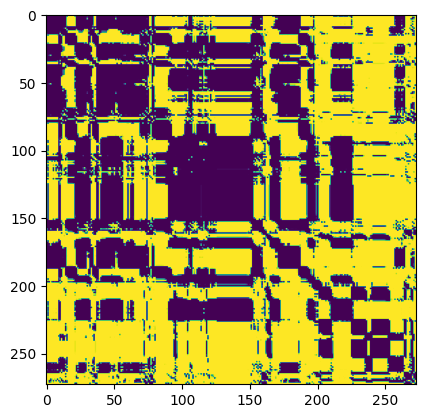

torch.Size([273, 273])
(287, 287)


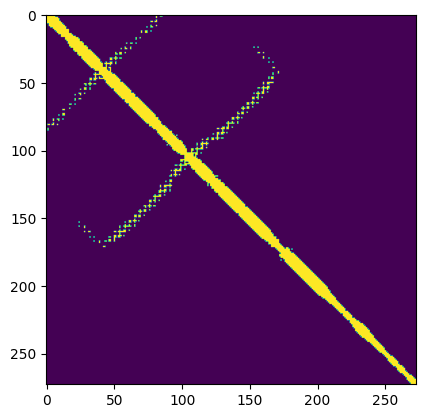

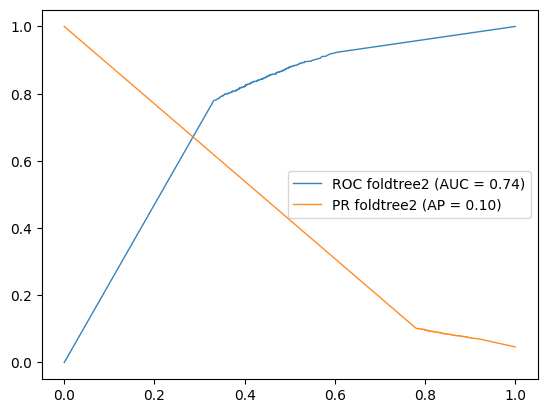

A0A380WB87


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

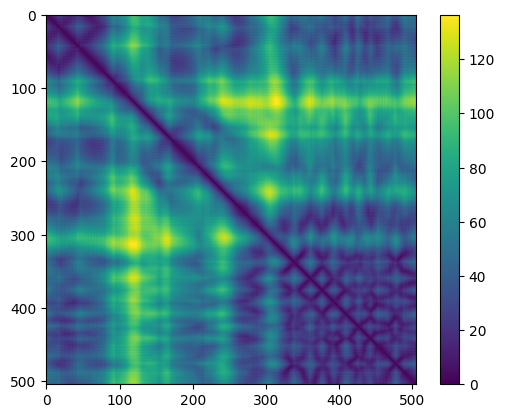

455
torch.Size([455, 20])
HeteroData(
  res={
    x=[455, 20],
    batch=[455],
  },
  positions={ x=[455, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 454] },
  (res, backbone_rev, res)={ edge_index=[2, 454] },
  (godnode4decoder, informs, res)={ edge_index=[2, 455] },
  (res, informs, godnode4decoder)={ edge_index=[2, 455] },
  (res, informs, godnode)={ edge_index=[2, 455] }
)
torch.Size([207025])
tensor([[-3.5356, -2.7683, -2.9128,  ..., -2.8734, -1.9194, -3.7954],
        [-3.8834, -2.8276, -2.8504,  ..., -2.6475, -1.5563, -4.1459],
        [-3.8075, -2.8953, -2.6962,  ..., -2.4638, -1.8467, -3.8211],
        ...,
        [-3.4785, -2.8466, -2.8590,  ..., -2.5036, -1.7885, -3.7410],
        [-2.1147, -2.8818, -3.9496,  ..., -6.3050, -6.4050, -2.1265],
        [-4.5064, -2.7832, -2.7717,  ..., -2.6264, -1.4507, -4.6252]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [

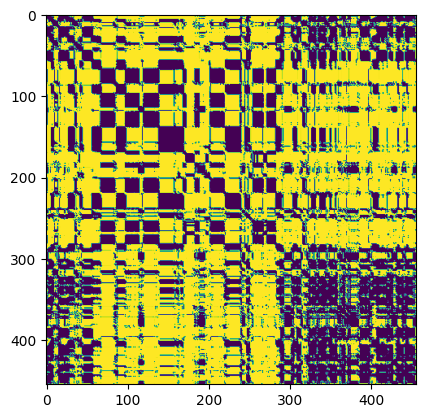

torch.Size([455, 455])
(505, 505)


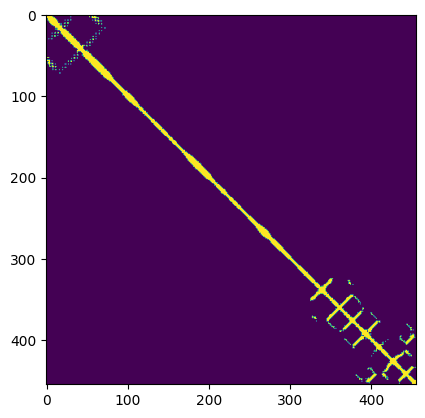

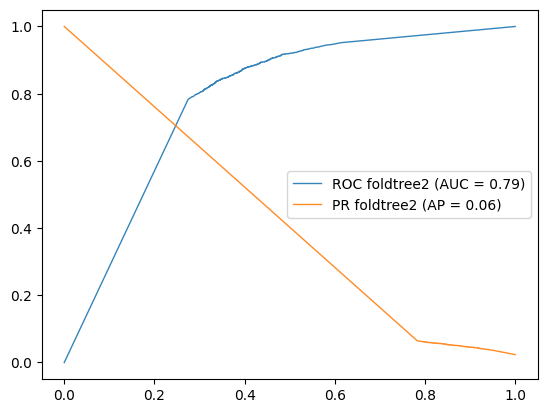

A0A3S4LZB0


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

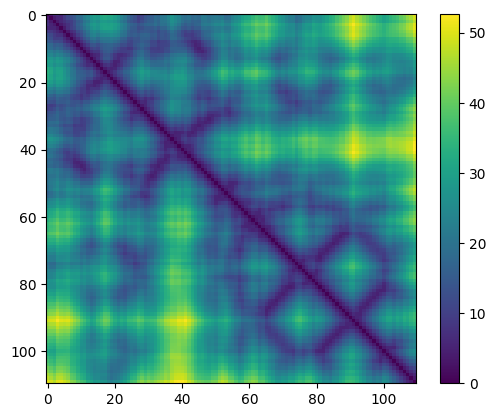

108
torch.Size([108, 20])
HeteroData(
  res={
    x=[108, 20],
    batch=[108],
  },
  positions={ x=[108, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 107] },
  (res, backbone_rev, res)={ edge_index=[2, 107] },
  (godnode4decoder, informs, res)={ edge_index=[2, 108] },
  (res, informs, godnode4decoder)={ edge_index=[2, 108] },
  (res, informs, godnode)={ edge_index=[2, 108] }
)
torch.Size([11664])
tensor([[-5.9056, -2.0669, -2.4507,  ..., -5.4115, -4.7551, -4.7125],
        [-5.9056, -2.0669, -2.4507,  ..., -5.4115, -4.7551, -4.7125],
        [-5.8942, -2.0710, -2.4607,  ..., -5.3840, -4.7342, -4.7164],
        ...,
        [-6.0749, -2.4130, -2.4416,  ..., -5.4028, -4.6863, -4.8915],
        [-3.7141, -2.8201, -3.1964,  ..., -6.1923, -5.7645, -4.7243],
        [-2.9138, -3.0745, -3.5087,  ..., -6.9131, -6.5969, -4.1176]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ...,

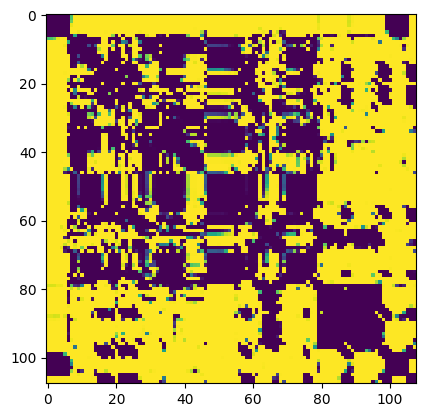

torch.Size([108, 108])
(110, 110)


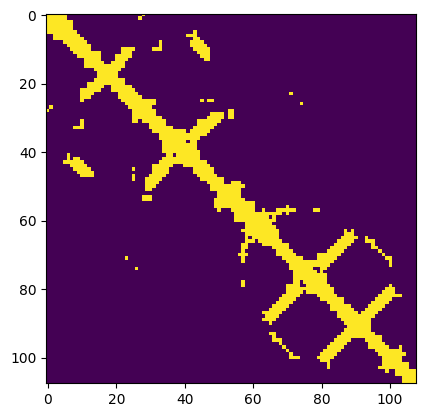

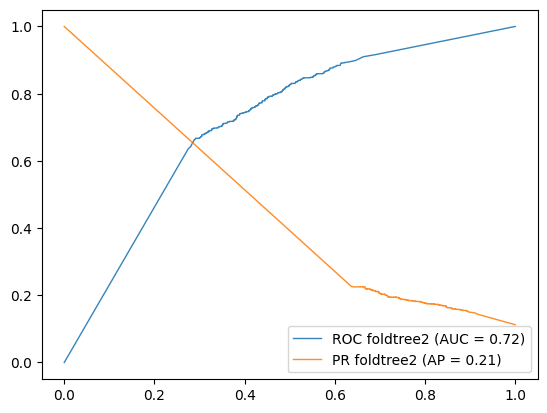

D6PJR2


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

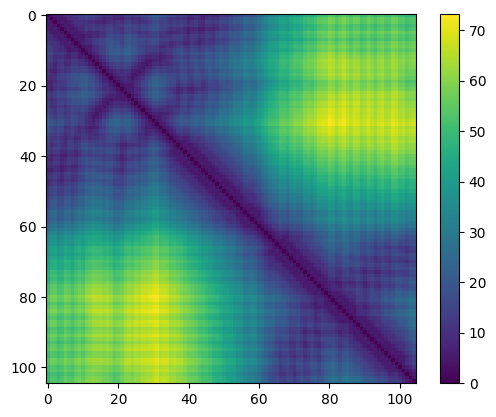

104
torch.Size([104, 20])
HeteroData(
  res={
    x=[104, 20],
    batch=[104],
  },
  positions={ x=[104, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 103] },
  (res, backbone_rev, res)={ edge_index=[2, 103] },
  (godnode4decoder, informs, res)={ edge_index=[2, 104] },
  (res, informs, godnode4decoder)={ edge_index=[2, 104] },
  (res, informs, godnode)={ edge_index=[2, 104] }
)
torch.Size([10816])
tensor([[-1.7423, -2.8041, -4.0266,  ..., -7.8086, -7.9078, -2.2720],
        [-1.8341, -3.0516, -4.3939,  ..., -7.6210, -8.1145, -1.9913],
        [-2.9742, -2.1984, -3.0778,  ..., -6.4308, -6.9360, -3.1598],
        ...,
        [-4.9866, -2.3390, -2.3409,  ..., -3.8081, -2.5785, -5.0291],
        [-3.7141, -2.8201, -3.1964,  ..., -6.1923, -5.7645, -4.7243],
        [-2.9138, -3.0745, -3.5087,  ..., -6.9131, -6.5969, -4.1176]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ...,

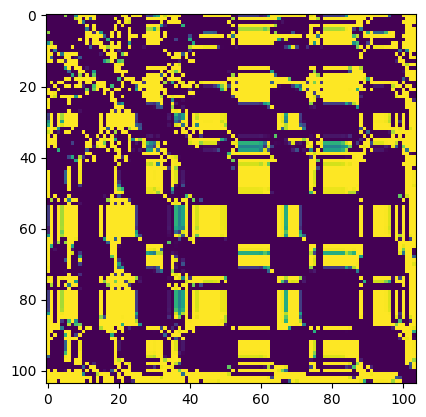

torch.Size([104, 104])
(105, 105)


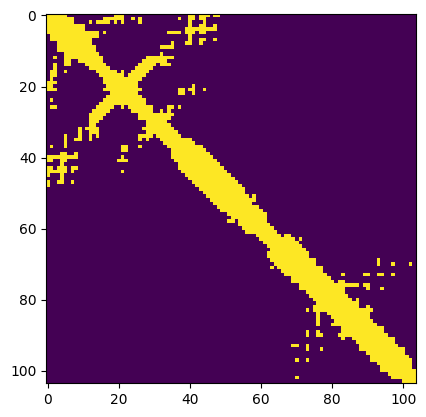

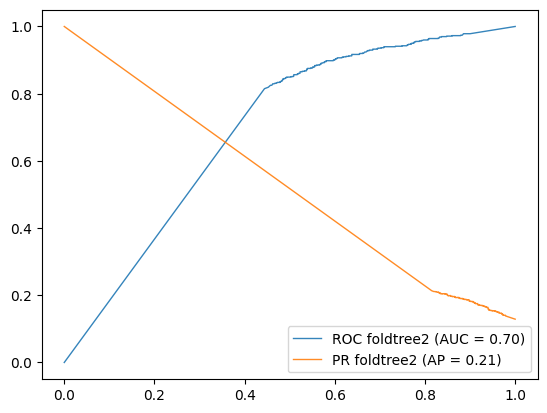

A0A328BRH7


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

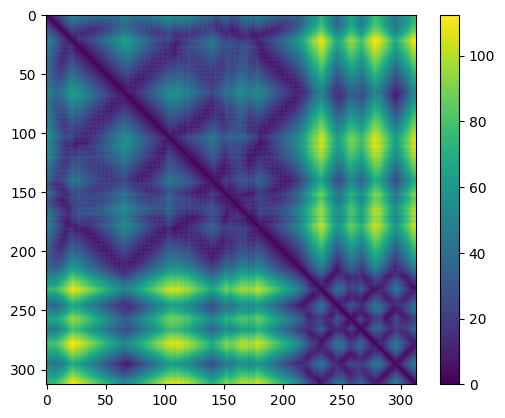

310
torch.Size([310, 20])
HeteroData(
  res={
    x=[310, 20],
    batch=[310],
  },
  positions={ x=[310, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 309] },
  (res, backbone_rev, res)={ edge_index=[2, 309] },
  (godnode4decoder, informs, res)={ edge_index=[2, 310] },
  (res, informs, godnode4decoder)={ edge_index=[2, 310] },
  (res, informs, godnode)={ edge_index=[2, 310] }
)
torch.Size([96100])
tensor([[-2.8430, -4.4472, -5.3215,  ..., -6.9869, -7.1427, -2.5139],
        [-2.5615, -4.4743, -5.1774,  ..., -7.0653, -7.3121, -2.4282],
        [-6.6330, -2.1065, -1.9323,  ..., -4.7048, -4.0264, -5.4263],
        ...,
        [-2.2653, -3.1578, -3.5624,  ..., -4.5759, -4.4505, -2.0278],
        [-1.9930, -3.4779, -4.0132,  ..., -6.0004, -5.9160, -1.7019],
        [-4.8722, -3.2536, -2.9823,  ..., -3.9215, -3.2126, -4.8939]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ...,

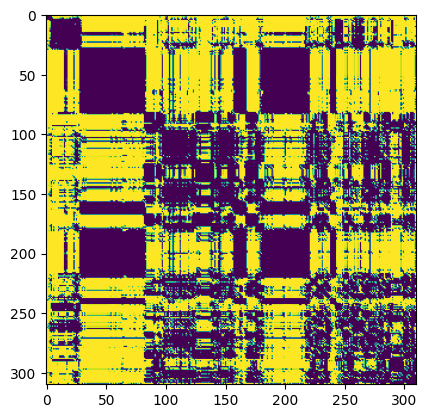

torch.Size([310, 310])
(313, 313)


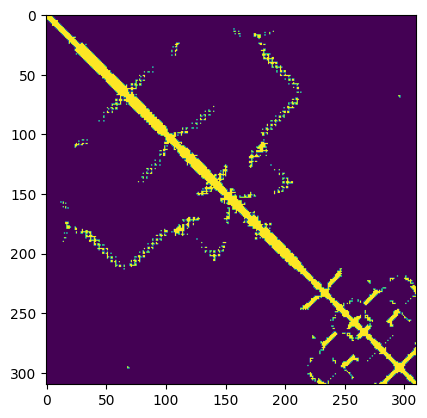

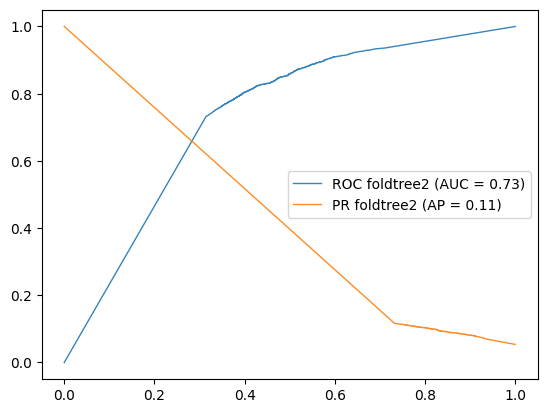

A0A6J6ZCZ6


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

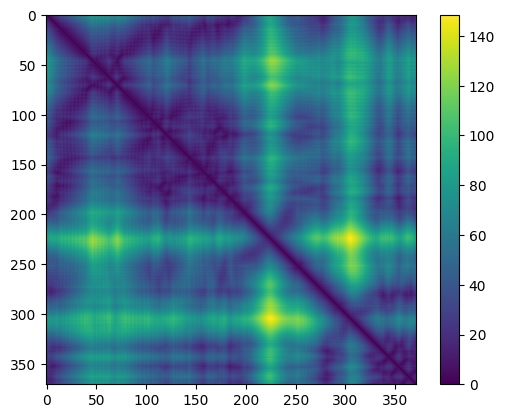

326
torch.Size([326, 20])
HeteroData(
  res={
    x=[326, 20],
    batch=[326],
  },
  positions={ x=[326, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 325] },
  (res, backbone_rev, res)={ edge_index=[2, 325] },
  (godnode4decoder, informs, res)={ edge_index=[2, 326] },
  (res, informs, godnode4decoder)={ edge_index=[2, 326] },
  (res, informs, godnode)={ edge_index=[2, 326] }
)
torch.Size([106276])
tensor([[-3.6548, -2.1525, -3.4782,  ..., -5.9062, -5.5858, -2.8881],
        [-3.3289, -3.3036, -3.7818,  ..., -6.1355, -6.2688, -2.6123],
        [-3.1537, -2.7483, -3.2940,  ..., -4.4121, -4.4753, -2.7824],
        ...,
        [-3.5944, -2.7013, -2.8176,  ..., -2.8451, -2.0068, -3.7775],
        [-4.3840, -2.5167, -2.5851,  ..., -2.8523, -1.7821, -4.5696],
        [-4.7844, -2.1767, -2.3011,  ..., -4.8612, -4.5906, -4.8023]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ...

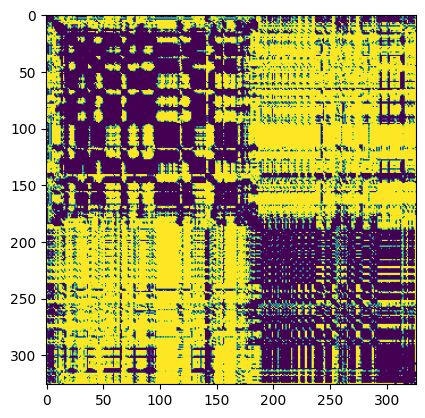

torch.Size([326, 326])
(371, 371)


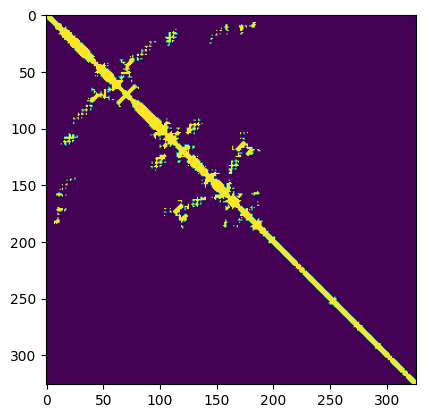

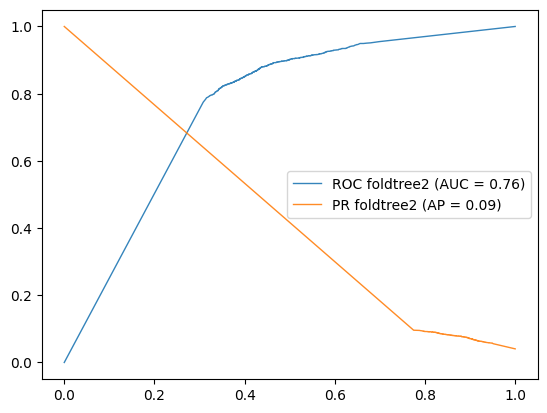

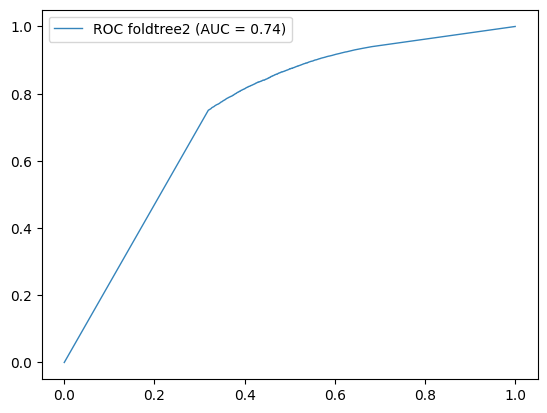

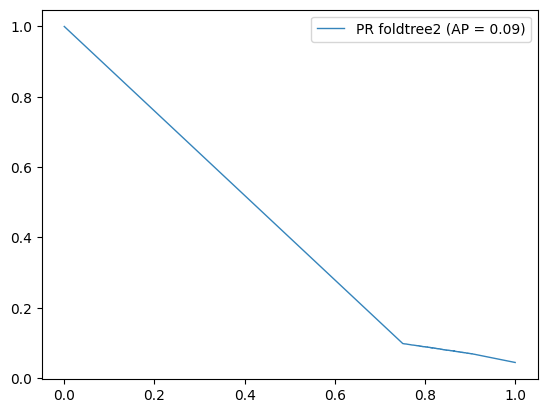

In [81]:
from Bio import PDB
from Bio.PDB import PDBParser
from sklearn.metrics import roc_curve, auc , precision_recall_curve, average_precision_score
from scipy import sparse
import torch_geometric

def get_alpha_carbon_distance_matrix(pdb_file):
	"""
	Extracts the alpha carbon (Cα) atoms from a PDB structure
	and computes the distance matrix in numpy format.

	Parameters:
	pdb_file (str): Path to the PDB file.

	Returns:
	numpy.ndarray: A matrix of distances between all Cα atoms.
	"""
	# Initialize the PDB parser
	parser = PDBParser(QUIET=True)
	
	# Parse the structure
	structure = parser.get_structure('structure', pdb_file)
	
	# Extract alpha carbon (Cα) atoms
	ca_atoms = []
	for model in structure:
		for chain in model:
			for residue in chain :
				if 'CA' in residue and PDB.is_aa(residue) :
					ca_atoms.append(residue['CA'])
	
	# Get the number of Cα atoms
	num_atoms = len(ca_atoms)
	
	# Initialize the distance matrix
	dist_matrix = np.zeros((num_atoms, num_atoms))
	
	# Compute the distances between all pairs of Cα atoms
	for i, atom_i in enumerate(ca_atoms):
		for j, atom_j in enumerate(ca_atoms):
			if i < j:
				dist_matrix[i, j] = atom_i - atom_j
	dist_matrix += dist_matrix.T
	return dist_matrix

#get aa and contacts
def get_backbone(naa):
	backbone_mat = np.zeros((naa, naa))
	backbone_rev_mat = np.zeros((naa, naa))
	np.fill_diagonal(backbone_mat[1:], 1)
	np.fill_diagonal(backbone_rev_mat[:, 1:], 1)
	return backbone_mat, backbone_rev_mat

def sparse2pairs(sparsemat):
	sparsemat = sparse.find(sparsemat)
	return np.vstack([sparsemat[0],sparsemat[1]])

def decoder_reconstruction2aa( ords , device, verbose = False):
	decoder.eval()
	z = encoder.vector_quantizer.embeddings( ords  ).to('cpu')
	print( z.shape)
	edge_index = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
	godnode_index = np.vstack([np.zeros(z.shape[0]), [ i for i in range(z.shape[0]) ] ])
	godnode_rev = np.vstack([ [ i for i in range(z.shape[0]) ] , np.zeros(z.shape[0]) ])
	#generate a backbone for the decoder
	data = HeteroData()
	data['res'].x = z
	backbone, backbone_rev = get_backbone( z.shape[0] )
	backbone = sparse.csr_matrix(backbone)
	backbone_rev = sparse.csr_matrix(backbone_rev)
	backbone = sparse2pairs(backbone)
	backbone_rev = sparse2pairs(backbone_rev)
	positional_encoding = converter.get_positional_encoding( z.shape[0] , 256 )
	data['res'].batch = torch.tensor([0 for i in range(z.shape[0])], dtype=torch.long)
	data['positions'].x = torch.tensor( positional_encoding, dtype=torch.float32)
	data['res','backbone','res'].edge_index = torch.tensor(backbone,  dtype=torch.long )
	data[ 'res' , 'backbone_rev' , 'res'].edge_index = torch.tensor(backbone_rev, dtype=torch.long)
	#add the godnode
	data['godnode'].x = torch.tensor(np.ones((1,5)), dtype=torch.float32)
	data['godnode4decoder'].x = torch.tensor(np.ones((1,5)), dtype=torch.float32)
	data['godnode4decoder', 'informs', 'res'].edge_index = torch.tensor(godnode_index, dtype=torch.long)
	data['res', 'informs', 'godnode4decoder'].edge_index = torch.tensor(godnode_rev, dtype=torch.long)
	data['res', 'informs', 'godnode'].edge_index = torch.tensor(godnode_rev, dtype=torch.long)
	edge_index = edge_index.to( device )
	print( data )
	data = data.to( device )
	allpairs = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
	recon_x , edge_probs , zgodnode , foldxout , r, t, angles= decoder( data , allpairs ) 
	print( edge_probs.shape)
	amino_map = decoder.amino_acid_indices
	revmap_aa = { v:k for k,v in amino_map.items() }
	edge_probs = edge_probs.reshape((z.shape[0], z.shape[0]))
	if verbose == True:
		print( recon_x )
		print( edge_probs )
	aastr = ''.join(revmap_aa[int(idx.item())] for idx in recon_x.argmax(dim=1) )
	return aastr ,edge_probs

postives = []
predictions = []
for ex in range( encoded_df.shape[0] ):
	os.makedirs('tmp', exist_ok=True)
	example = encoded_df.iloc[ex]
	protid = encoded_df.index[ex]
	ords = example['ord']
	print( str(protid))
	AFDB_tools.grab_struct(str(protid) , structfolder='tmp/')
	#show struct
	view_custom_pdb('tmp/' + protid + '.pdb', chain='A')
	#get alpha carbon distmat with biopython
	s = get_alpha_carbon_distance_matrix( 'tmp/' + protid + '.pdb')
	#threshold the distance matrix
	plt.imshow(s)
	plt.colorbar()
	plt.show()
	#these are the embedding indices. shift by 1 to get the hex indices
	ords = torch.tensor([ c-1 if c not in rev_replace_dict_ord else rev_replace_dict_ord[c]-1 for c in ords] , dtype=torch.long)
	print( len(ords))
	ords = ords.to(device)	
	aa, edgeprobs = decoder_reconstruction2aa( ords , device = device, verbose = True)
	print(aa)
	#change range of image to 0-1
	probs = 1-edgeprobs.detach().cpu()
	probs = (probs + probs.T)/2
	plt.imshow(probs) 
	plt.show()
	print( probs.shape)
	print( s.shape)
	#output ROC curve for contact prediction

	pos = np.zeros( s.shape )
	pos[ s < 10] = 1
	pos = pos[ 0:probs.shape[0], 0:probs.shape[1]]
	plt.imshow(pos)
	plt.show()

	postives.append(pos.flatten())
	predictions.append(probs.flatten())

	#flatten the matrices
	pos = pos.flatten()
	probs = probs.flatten()
	fpr, tpr, thresholds = roc_curve(pos, 1-probs)
	roc_auc = auc(fpr, tpr)
	plt.plot(fpr, tpr, lw=1, alpha=0.9, label='ROC foldtree2 (AUC = %0.2f)' % (roc_auc))

	#output precision recall curve
	precision, recall, thresholds = precision_recall_curve(pos, 1-probs)
	average_precision = average_precision_score(pos, 1-probs)
	plt.plot(recall, precision, lw=1, alpha=0.9, label='PR foldtree2 (AP = %0.2f)' % (average_precision))
	plt.legend()
	plt.show()

#output ROC curve for contact prediction
postives = np.concatenate(postives)
predictions = np.concatenate(predictions)
fpr, tpr, thresholds = roc_curve(postives, 1-predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.9, label='ROC foldtree2 (AUC = %0.2f)' % (roc_auc))
plt.legend()
plt.show()

#output precision recall curve
precision, recall, thresholds = precision_recall_curve(postives, 1-predictions)
average_precision = average_precision_score(postives, 1-predictions)
plt.plot(recall, precision, lw=1, alpha=0.9, label='PR foldtree2 (AP = %0.2f)' % (average_precision))
plt.legend()
plt.show()


In [73]:
# Function to compute Root Mean Square Deviation (RMSD)
def compute_rmsd(coords1, coords2):
    """
    Compute the Root Mean Square Deviation (RMSD) between two sets of coordinates.
    
    Parameters:
    - coords1: Nx3 NumPy array of true coordinates
    - coords2: Nx3 NumPy array of predicted coordinates
    
    Returns:
    - RMSD value
    """
    assert coords1.shape == coords2.shape, "Coordinate arrays must have the same shape"
    
    diff = coords1 - coords2
    rmsd = np.sqrt(np.mean(np.sum(diff**2, axis=1)))
    return rmsd

# Function to compute Local Distance Difference Test (lDDT)
def compute_lddt(true_coords, pred_coords, cutoff=15.0):
    """
    Compute the Local Distance Difference Test (lDDT) score.
    
    Parameters:
    - true_coords: Nx3 NumPy array of true coordinates
    - pred_coords: Nx3 NumPy array of predicted coordinates
    - cutoff: Distance threshold for considering a pair of residues
    
    Returns:
    - lDDT score (0 to 1)
    """
    assert true_coords.shape == pred_coords.shape, "Coordinate arrays must have the same shape"

    num_residues = true_coords.shape[0]
    num_pairs = 0
    num_matching_pairs = 0

    for i in range(num_residues):
        for j in range(i + 1, num_residues):
            true_dist = np.linalg.norm(true_coords[i] - true_coords[j])
            pred_dist = np.linalg.norm(pred_coords[i] - pred_coords[j])

            if true_dist < cutoff:
                num_pairs += 1
                if abs(true_dist - pred_dist) < 0.5 * true_dist:
                    num_matching_pairs += 1

    lddt_score = num_matching_pairs / num_pairs if num_pairs > 0 else 0
    return lddt_score

# Compute RMSD and lDDT
rmsd_value = compute_rmsd(true_coords_from_rt, pred_coords_from_rt)
lddt_value = compute_lddt(true_coords_from_rt, pred_coords_from_rt)

rmsd_value, lddt_value


NameError: name 'true_coords_from_rt' is not defined

In [83]:

#plot the true and predicted structures
def transform_rt_to_coordinates(rotations, translations):
    """
    Given a list of rotation matrices (R) and translation vectors (t),
    generate the global 3D coordinates of the protein backbone.
    
    Parameters:
    - rotations: List of 3x3 rotation matrices
    - translations: List of 3x1 translation vectors
    
    Returns:
    - coords: Nx3 NumPy array representing the backbone in 3D space
    """
    num_residues = len(rotations)
    assert num_residues == len(translations), "Rotation and translation lists must be the same length"
    
    # Initialize the first coordinate at the origin
    coords = [np.array([0, 0, 0, 1])]  # Homogeneous coordinates

    # Apply transformations iteratively
    current_transform = np.eye(4)  # Identity matrix as starting point

    for R, t in zip(rotations, translations):
        # Construct the transformation matrix (4x4)
        T = np.eye(4)
        T[:3, :3] = R
        T[:3, 3] = t
        
        # Update the cumulative transformation
        current_transform = current_transform @ T
        
        # Transform the point and store the new coordinates
        new_point = current_transform @ np.array([0, 0, 0, 1])  # Homogeneous coordinates
        coords.append(new_point)

    return np.array(coords)[:, :3]  # Convert back to 3D coordinates (drop the homogeneous coordinate)


def plot_protein_structures_with_thicker_lines(true_coords, pred_coords):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot true structure with thicker lines and transparency
    ax.plot(true_coords[:, 0], true_coords[:, 1], true_coords[:, 2], 
            'bo-', alpha=0.5, label='True Structure', linewidth=3, markersize=6)

    # Plot predicted structure with thicker lines and transparency
    ax.plot(pred_coords[:, 0], pred_coords[:, 1], pred_coords[:, 2], 
            'ro-', alpha=0.5, label='Predicted Structure', linewidth=3, markersize=6)

    # Adjusted arrow size
    arrow_size = 0.15  # Keep small arrows

    # Add arrowheads to indicate backbone direction
    for i in range(len(true_coords) - 1):
        ax.quiver(true_coords[i, 0], true_coords[i, 1], true_coords[i, 2],
                  true_coords[i+1, 0] - true_coords[i, 0], 
                  true_coords[i+1, 1] - true_coords[i, 1], 
                  true_coords[i+1, 2] - true_coords[i, 2],
                  color='blue', alpha=0.5, arrow_length_ratio=arrow_size)

    for i in range(len(pred_coords) - 1):
        ax.quiver(pred_coords[i, 0], pred_coords[i, 1], pred_coords[i, 2],
                  pred_coords[i+1, 0] - pred_coords[i, 0], 
                  pred_coords[i+1, 1] - pred_coords[i, 1], 
                  pred_coords[i+1, 2] - pred_coords[i, 2],
                  color='red', alpha=0.5, arrow_length_ratio=arrow_size)

    # Labels and legend
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('True vs Predicted Protein Backbone Structure with Thicker Lines')
    ax.legend()

    plt.show()

# Plot with thicker lines
plot_protein_structures_with_thicker_lines(true_coords, noisy_pred_coords)


NameError: name 'true_coords' is not defined